In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Display some predictions."""
import os
from pathlib import Path
import numpy as np
from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt
from nmp import dataset
# from tensorflow.keras.layers import LSTM
import tensorflow as tf
import copy
import pandas as pd
from nmp.dataset import pyplot_piano_roll, write_midi
from nmp import model as mod
import matplotlib.pyplot as plt
import time
import pypianoroll
import random

P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook

PLOTS = P / 'plots'  # Plots path
BS = 64
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12  # Downsampling factor
# D = "data/Nottingham/test"  # Dataset (synth or data)
# D = "data/Piano-midi.de/test"  # Dataset (synth or data)
D = "data/POP909" # Dataset
# D = "data/JSB Chorales/test"  # Dataset (synth or data)

# MODEL = 'simpleRNN-nottingham-3.h5'
# MODEL_FF = 'ff-z-nottingham'
MODEL = 'ff-1'
# model_type = 'rnn'

LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

# LOW_LIM = 36  # A1
# HIGH_LIM = 85  # C7

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

# TensorFlow stuff
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
# Load model.
# model = load_model(filepath=str(P / 'models' / MODEL),
#                    custom_objects=None, compile=True)
# model.summary()

from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
import keras.metrics

LOAD = 0
if LOAD:
    model = load_model(filepath=model_path,
                       custom_objects=None,
                       compile=True)

else:
    model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy', mod.f1, keras.metrics.Precision(), keras.metrics.Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 640)               21120     
Total params: 33,472
Trainable params: 33,472
Non-trainable params: 0
_________________________________________________________________


In [3]:
# checkpoint_dir = P / ('models/take/lstm-jsb')
# model = mod.build_gru_model(NUM_NOTES, 1)
# mod.compile_model(model, 'binary_crossentropy', 'adam',
#                   metrics=['accuracy'])
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# model.build(tf.TensorShape([1, None]))
# model.summary()

In [4]:
##### CHECK THIS
# checkpoint_dir = P / ('models/ff-1')
# model_ff = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
# mod.compile_model(model_ff, 'binary_crossentropy', 'adam',
#                   metrics=['accuracy', mod.f1])
# model_ff.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# model_ff.build(tf.TensorShape([1, None]))
# model_ff.summary()

In [6]:
# model_ff = load_model(filepath=str(P / 'models' / MODEL_FF),
#                    custom_objects=None, compile=True)
# model.summary()

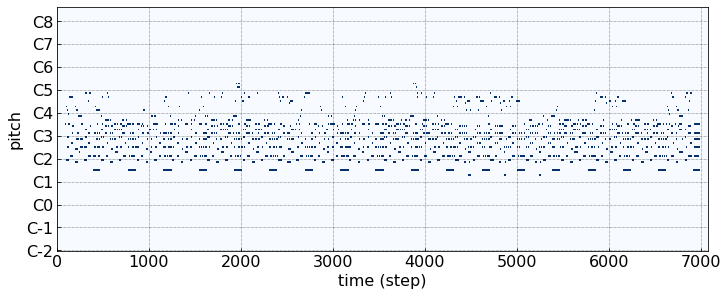

In [22]:
BASE = 0
hm = 4

# FILE = D + '/' + 'ashover_simple_chords_5.mid'
# FILE = 'midi_tests/pattern4BIS.mid'
# FILE = 'midi_tests/bach-minuetto3.mid'
# FILE = D + '/' + 'ashover_simple_chords_5.mid'  # Nottingham
# TRACK = 'alb_esp2.mid'
TRACK = 'test/001.mid'
FILE = D + '/' + TRACK
test_file = dataset.import_one(str(FILE), 24)

# FILE = 'jigs_simple_chords_17.mid'
# FILE = 'jigs_simple_chords_101.mid'
# FILE = 'playford_simple_chords_5.mid'
# FILE = 'jigs_simple_chords_227.mid'


test_file = test_file[:, LOW_LIM:HIGH_LIM]
pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM)
STOP = 960

In [7]:
print(test_file.shape)

model.reset_states()
m = 12
random.seed(3)
before = copy.deepcopy(test_file)
# ff_file = copy.deepcopy(test_file)
# base_file = copy.deepcopy(test_file)

err_pos = range(2, int(test_file.shape[0]/(24*m)))
err_pos = [x*24*m + 12 for x in err_pos]

# err_pos=[288]
# err_pos = [100]
# for error in [60*x for x in range(1, 50)]:
errors = []
size = 10
for error in err_pos:
    occurs = random.choice([1])
    if occurs:
        errors.append(error)
        print("Error at timestep n. %d" % error)
        try:
#             ff_file = dataset.fill_gap(ff_file, model_ff, error, size=size, baseline=BASE, how_many=hm)
#             test_file = dataset.fill_gap_rnn_final(test_file, model, error, size=size, baseline=BASE, how_many=hm)
#             base_file = dataset.fill_gap_hold(base_file, error, size=size)
            test_file = dataset.fill_gap(test_file, model, error, size=size, baseline=BASE, how_many=hm)

        except Exception as e:
            print(e)
print("test_file shape: ", test_file.shape)
print("errors: ", errors)

(7080, 64)
Error at timestep n. 588
Error at timestep n. 876
Error at timestep n. 1164
Error at timestep n. 1452
Error at timestep n. 1740
Error at timestep n. 2028
Error at timestep n. 2316
Error at timestep n. 2604
Error at timestep n. 2892
Error at timestep n. 3180
Error at timestep n. 3468
Error at timestep n. 3756
Error at timestep n. 4044
Error at timestep n. 4332
Error at timestep n. 4620
Error at timestep n. 4908
Error at timestep n. 5196
Error at timestep n. 5484
Error at timestep n. 5772
Error at timestep n. 6060
Error at timestep n. 6348
Error at timestep n. 6636
test_file shape:  (7080, 64)
errors:  [588, 876, 1164, 1452, 1740, 2028, 2316, 2604, 2892, 3180, 3468, 3756, 4044, 4332, 4620, 4908, 5196, 5484, 5772, 6060, 6348, 6636]


In [8]:
if errors[-1] > test_file.shape[0]:
    errors.pop()

/home/cuy/anaconda3/envs/newtest/lib/python3.7/site-packages/pypianoroll/visualization.py:346: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


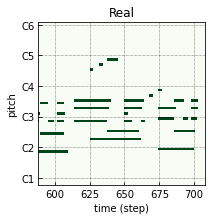

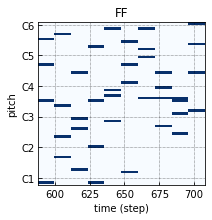

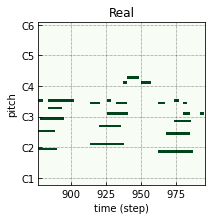

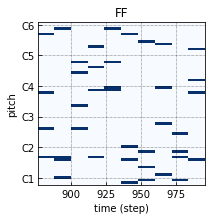

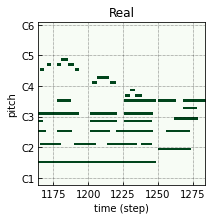

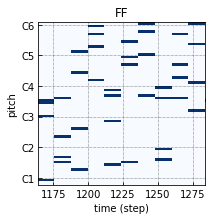

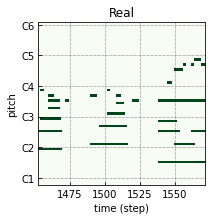

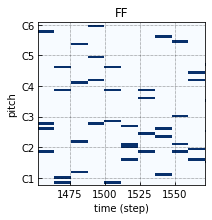

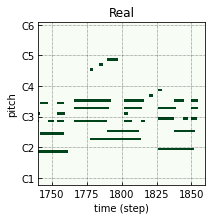

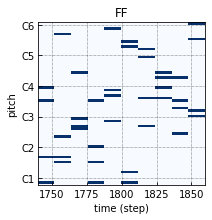

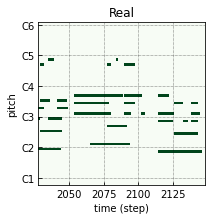

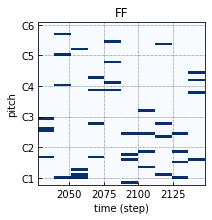

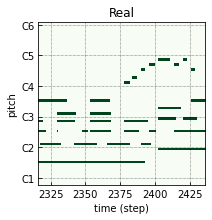

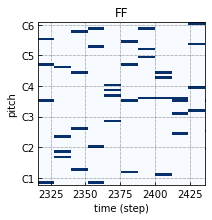

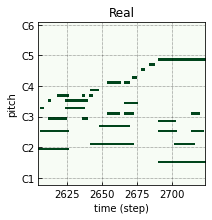

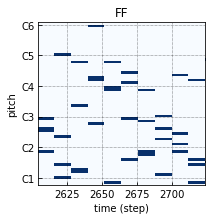

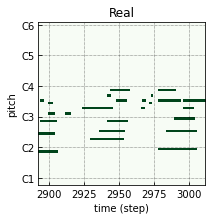

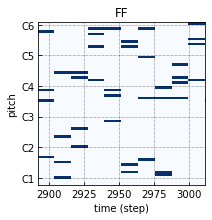

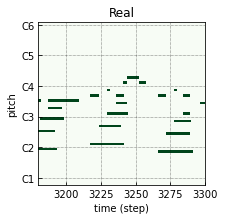

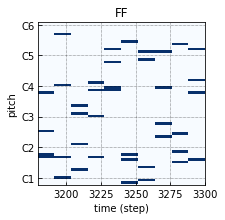

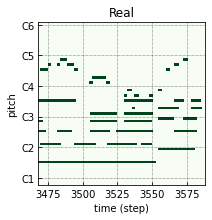

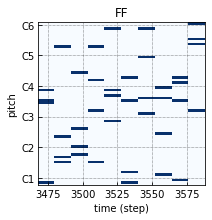

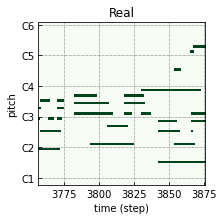

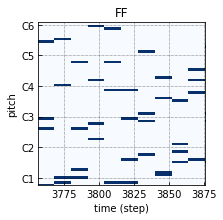

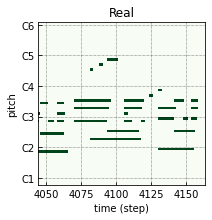

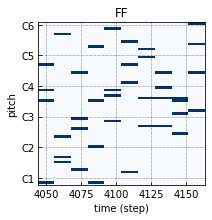

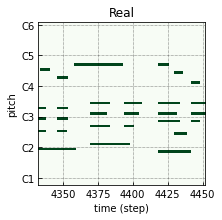

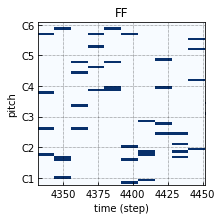

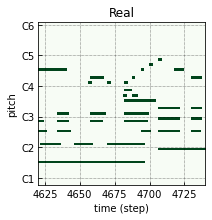

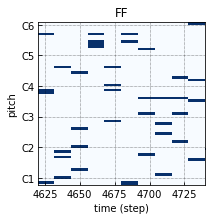

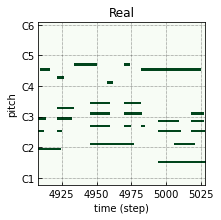

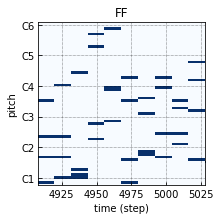

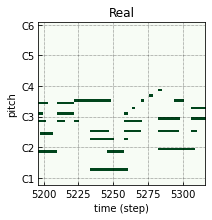

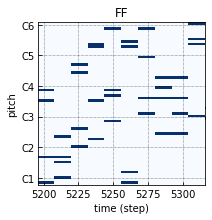

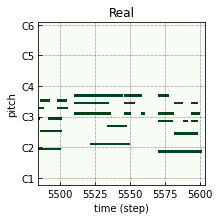

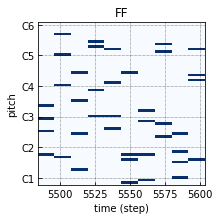

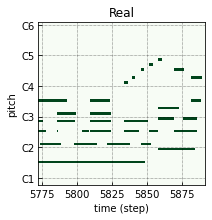

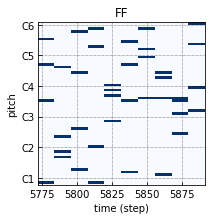

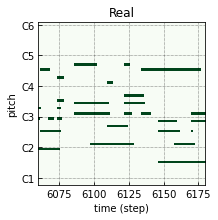

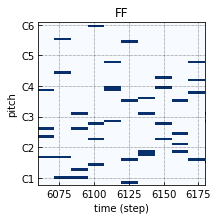

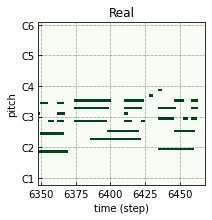

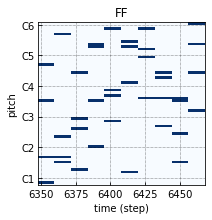

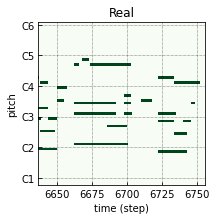

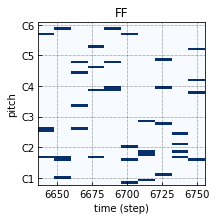

In [9]:
plt.rcParams["figure.figsize"] = (3, 3)
plt.rc('text', usetex=False)
for e in errors:
    x1 = e
    x2 = e + size*12
    xcrop = [e, e + size*12]
    pyplot_piano_roll(before, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Greens')
    plt.ylim([33, 97])
    plt.xlim(xcrop)
    plt.title("Real")
#     pyplot_piano_roll(ff_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Reds')
#     plt.ylim([33, 97])
#     plt.xlim(xcrop)
#     plt.title("Feed forward")
    pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Blues')
    plt.ylim([33, 97])
    plt.xlim(xcrop)
    plt.title("FF")
#     pyplot_piano_roll(base_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Blues')
#     plt.ylim([33, 97])
#     plt.xlim(xcrop)
#     plt.title("Hold baseline")
    continue


In [10]:
db = []
db += [e for e in errors]
db += [e+size*12 for e in errors]
db.sort()
print(db)

[588, 708, 876, 996, 1164, 1284, 1452, 1572, 1740, 1860, 2028, 2148, 2316, 2436, 2604, 2724, 2892, 3012, 3180, 3300, 3468, 3588, 3756, 3876, 4044, 4164, 4332, 4452, 4620, 4740, 4908, 5028, 5196, 5316, 5484, 5604, 5772, 5892, 6060, 6180, 6348, 6468, 6636, 6756]


/home/cuy/anaconda3/envs/newtest/lib/python3.7/site-packages/pypianoroll/visualization.py:544: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(hspace=0)
/home/cuy/anaconda3/envs/newtest/lib/python3.7/site-packages/pypianoroll/visualization.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(num_track, sharex=True)
findfont: Font family ['custom'] not found. Falling back to DejaVu Sans.


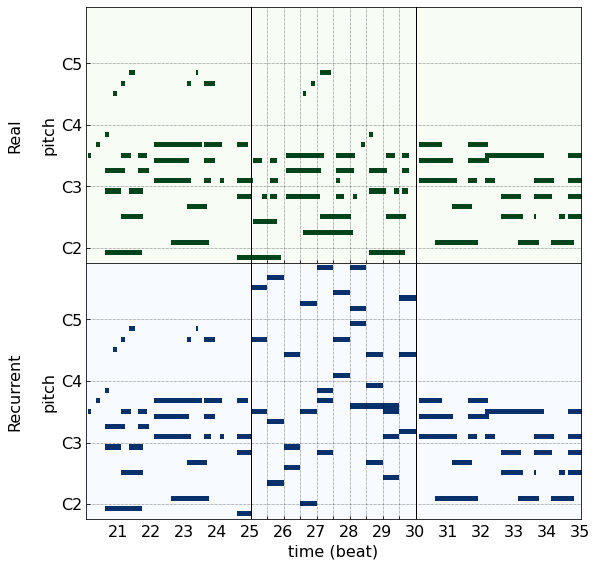

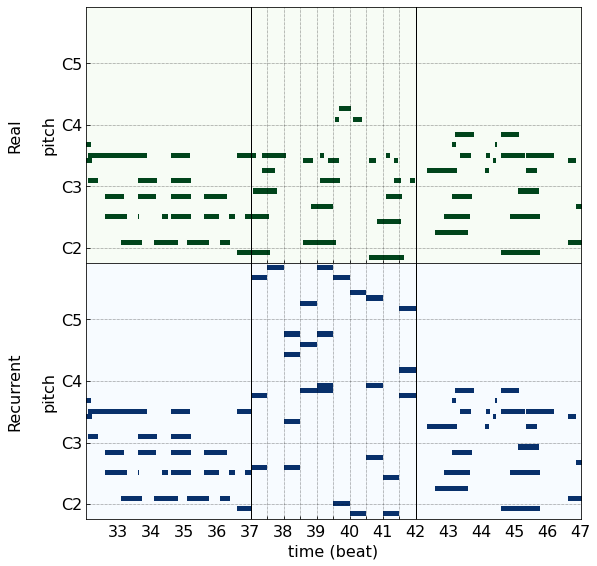

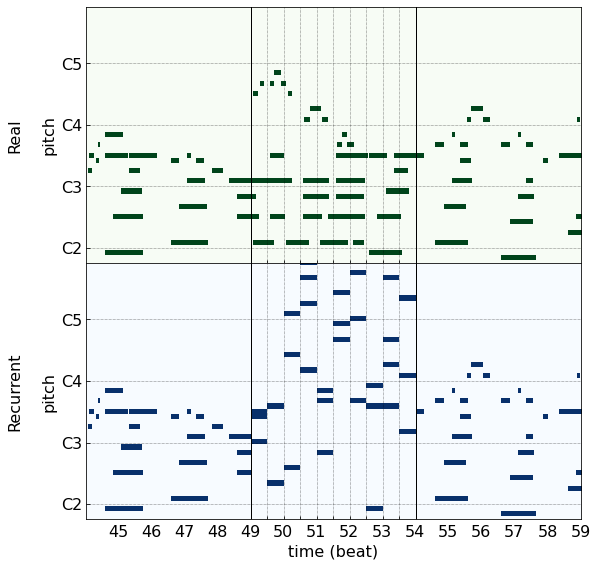

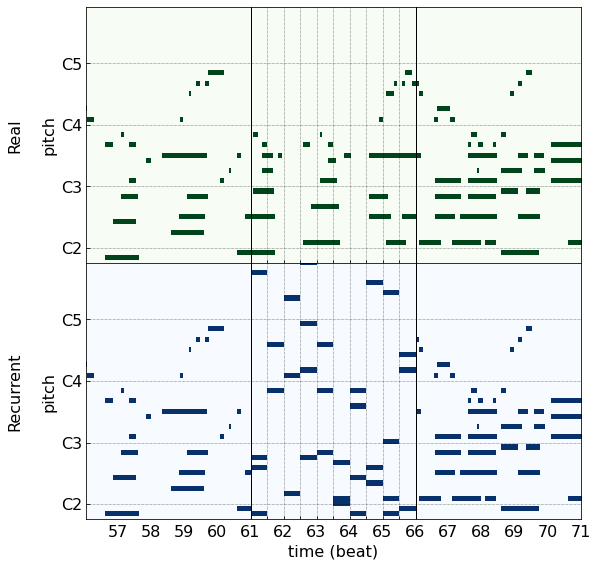

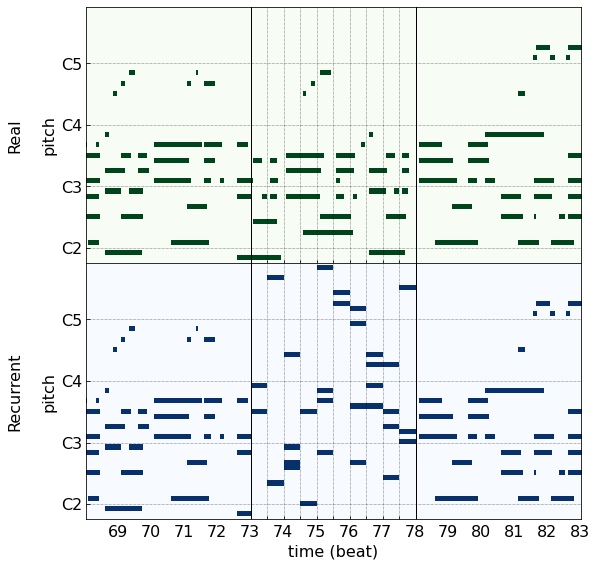

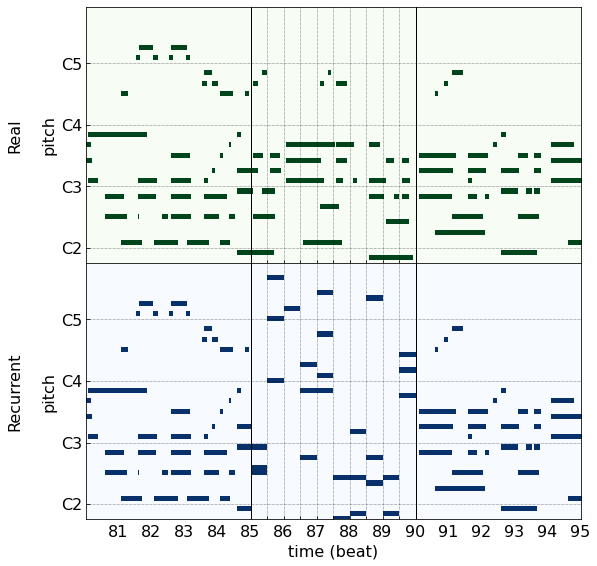

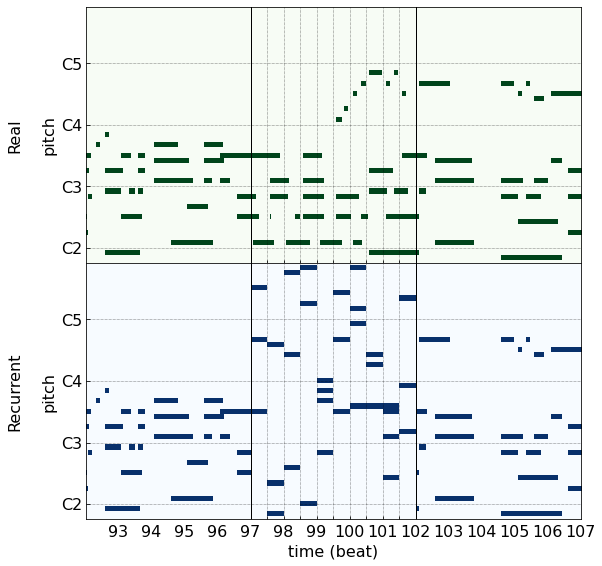

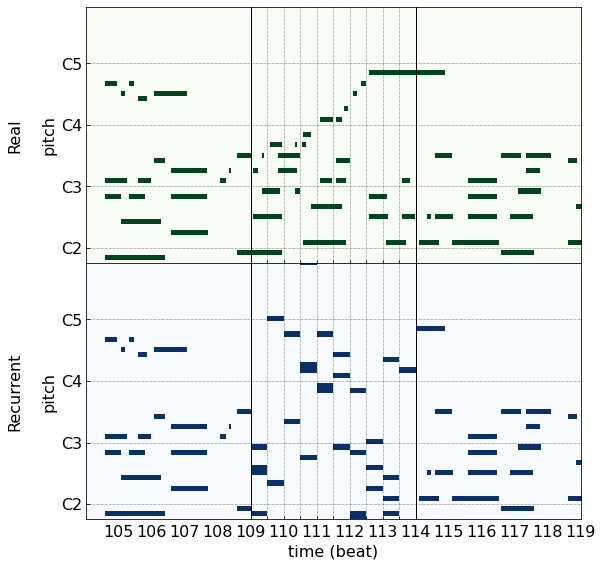

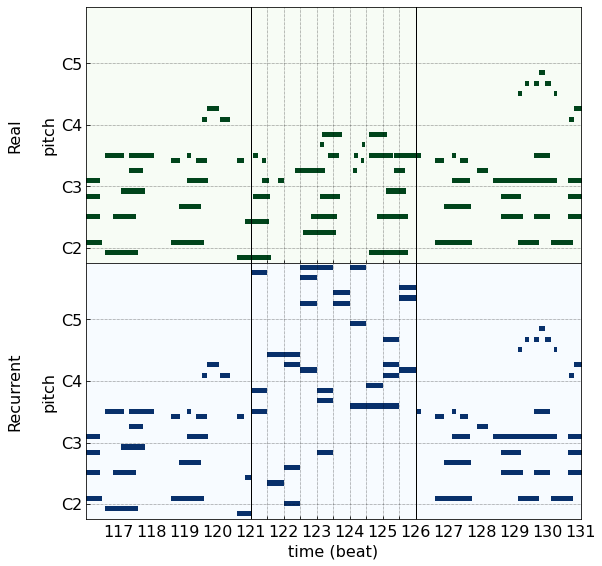

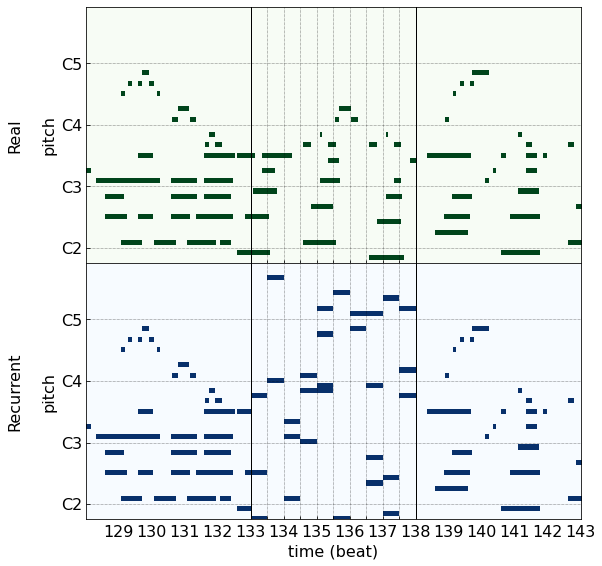

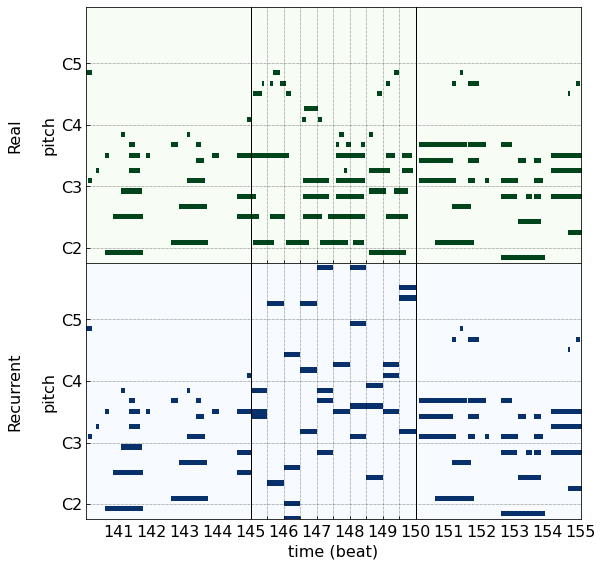

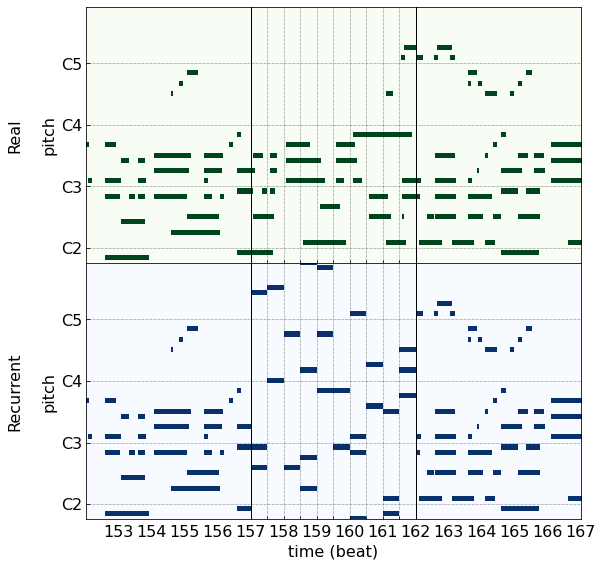

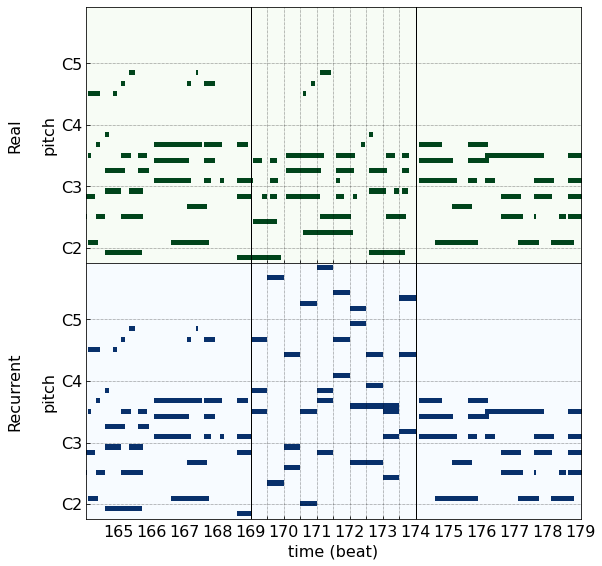

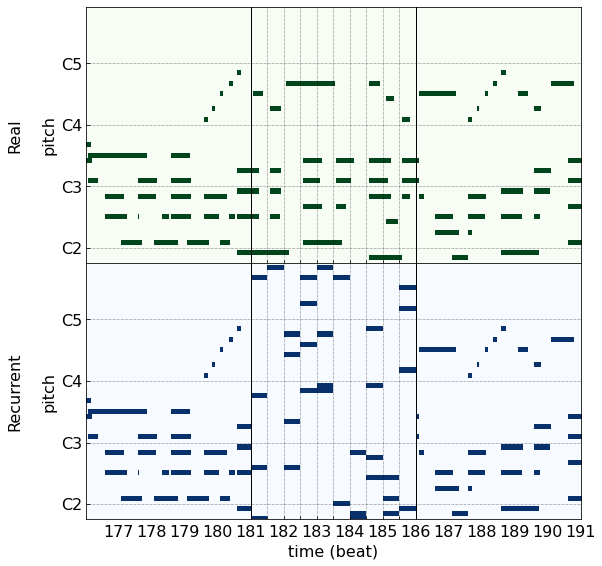

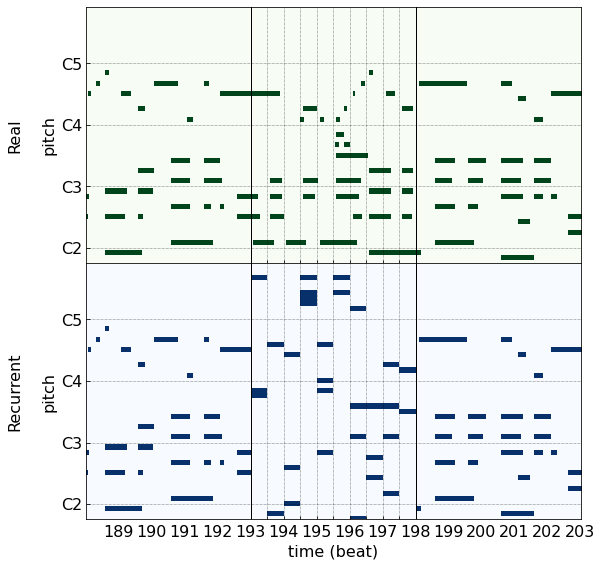

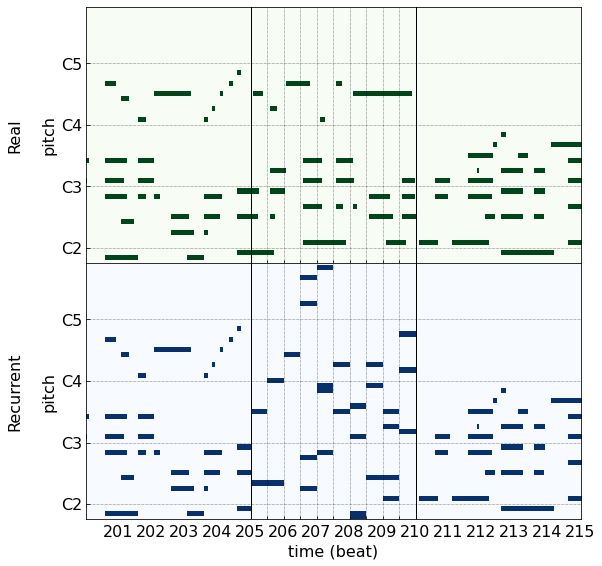

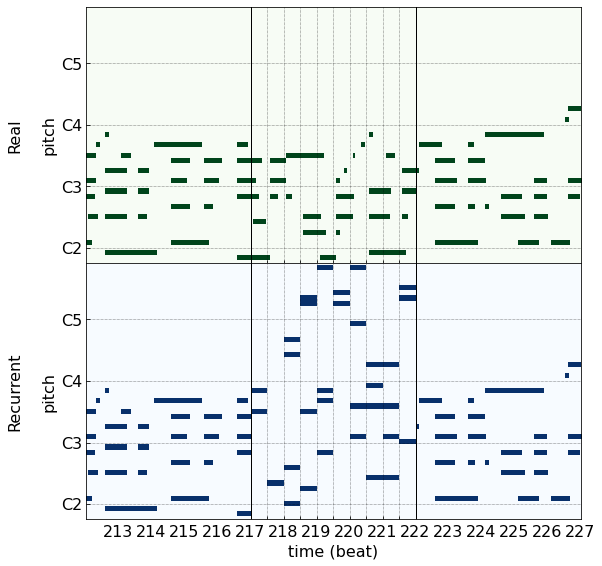

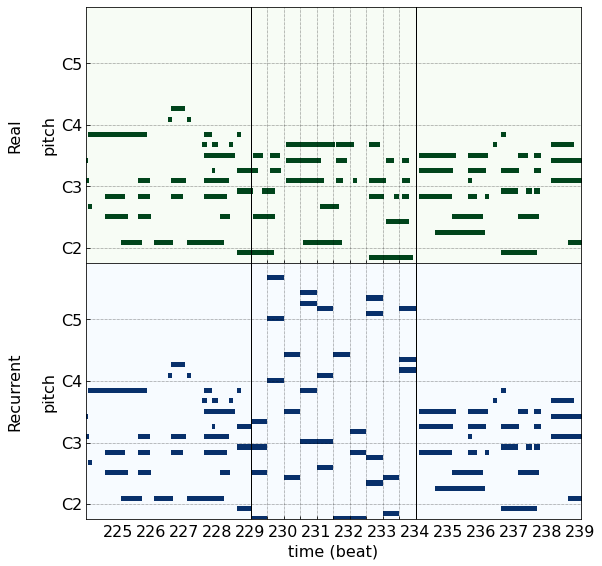

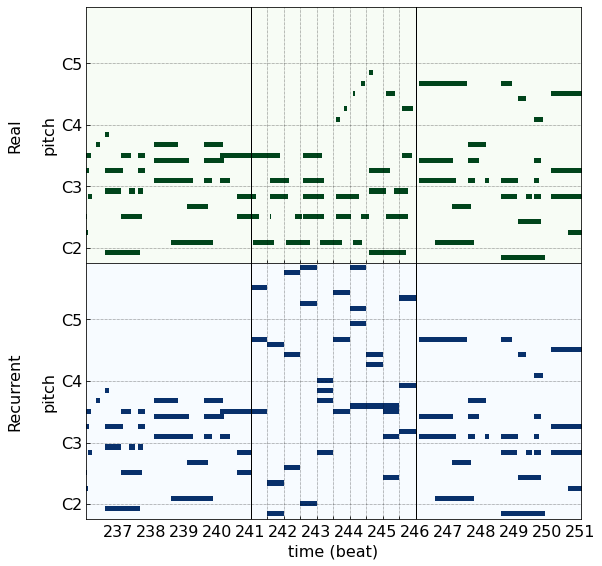

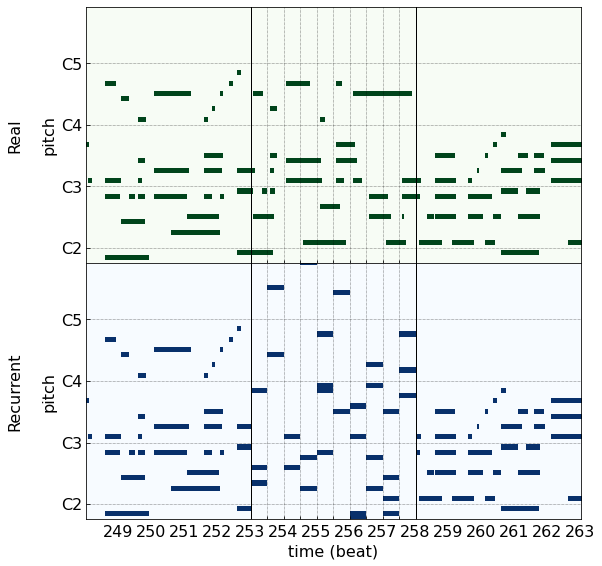

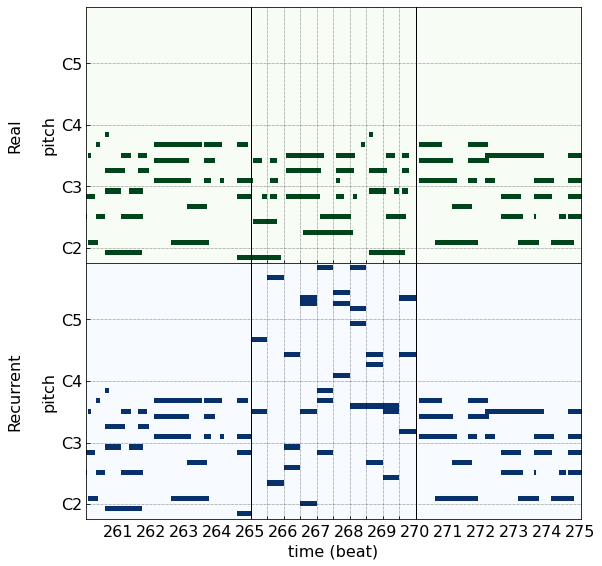

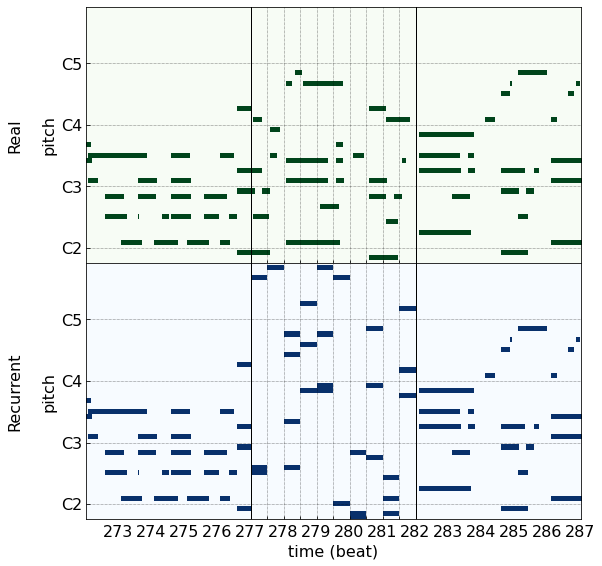

In [11]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.constrained_layout.use"] = True
# plt.rcParams["figure.constrained_layout.use"] = False

import matplotlib
from matplotlib import rc
matplotlib.rcParams['mathtext.rm'] = 'custom'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['font.family'] = 'custom'

# rc('text', usetex=True)
rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{classicthesis}')
plt.rcParams.update({'font.size': 16})

tr1 = pypianoroll.Track(dataset.pad_piano_roll(before, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Real')
# tr2 = pypianoroll.Track(dataset.pad_piano_roll(ff_file, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Feedforward')
tr3 = pypianoroll.Track(dataset.pad_piano_roll(test_file, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Recurrent')
# tr4 = pypianoroll.Track(dataset.pad_piano_roll(base_file, low_lim=LOW_LIM, high_lim=HIGH_LIM), name='Baseline')

# multitrack = pypianoroll.Multitrack(tracks=[tr1, tr2, tr3, tr4], downbeat=db)
multitrack = pypianoroll.Multitrack(tracks=[tr1, tr3], downbeat=db)
for cnt, e in enumerate(errors):
    x1 = e
    x2 = e + size*12
    xcrop = [e-120, e + size*12 + 120]
    fig, axs = multitrack.plot(xtick='auto', cmaps=['Greens', 'Blues', 'Reds', 'Purples'])
    for ax in axs:
        ax.set_xlim(xcrop)
        ax.set_ylim([45, 95])
#         ax.set_ylim([50, 75])
        ax.set_xticks([e + 12*i for i in range(size+1)])
    plt.gcf().subplots_adjust(left=0.12)
    plt.gcf().subplots_adjust(right=0.98)
    plt.gcf().subplots_adjust(top=0.99)
    plt.gcf().subplots_adjust(bottom=0.1)
#     plt.tight_layout()
#     plt.savefig(PLOTS / 'gaps' / (TRACK + '_gap_' + str(cnt) + '.png'), dpi=300)
#     print("Figure saved: " + str(PLOTS / (TRACK + 'gaps') / ('gap_' + str(cnt) + '.png')))
#     break


In [12]:
# assert False

(33.0, 97.0)

findfont: Font family ['custom'] not found. Falling back to DejaVu Sans.


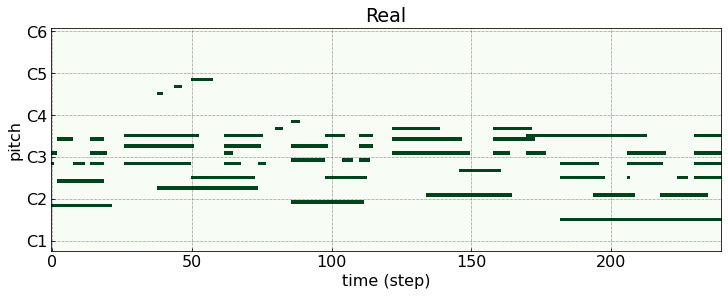

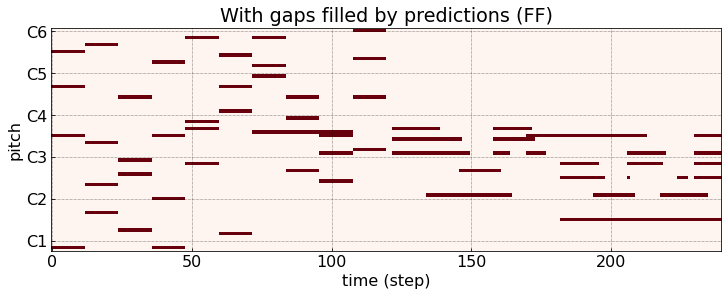

In [13]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rc('text', usetex=False)
x1 = errors[0]
x2 = errors[0] + 240
pyplot_piano_roll(before[x1:x2], low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Greens')
plt.title("Real")
plt.ylim([33, 97])

pyplot_piano_roll(test_file[x1:x2], low_lim=+LOW_LIM, high_lim=HIGH_LIM, cmap='Reds')
plt.title("With gaps filled by predictions (FF)")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-ff.png'))

[588, 876, 1164, 1452, 1740, 2028, 2316, 2604, 2892, 3180, 3468, 3756, 4044, 4332, 4620, 4908, 5196, 5484, 5772, 6060, 6348, 6636]
[588, 708, 876, 996, 1164, 1284, 1452, 1572, 1740, 1860, 2028, 2148, 2316, 2436, 2604, 2724, 2892, 3012, 3180, 3300, 3468, 3588, 3756, 3876, 4044, 4164, 4332, 4452, 4620, 4740, 4908, 5028, 5196, 5316, 5484, 5604, 5772, 5892, 6060, 6180, 6348, 6468, 6636, 6756]


(33.0, 97.0)

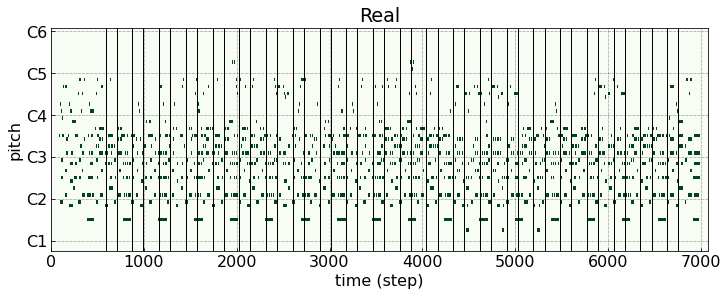

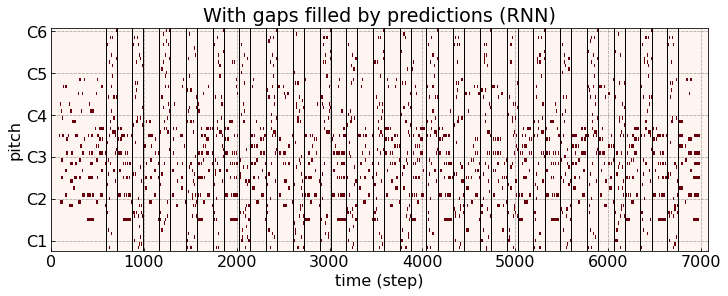

In [14]:
plt.rcParams["figure.figsize"] = (10, 4)
dbs=[y+x for y in errors for x in [0, 120]]
print(errors)
print(dbs)
pyplot_piano_roll(before, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Greens')
plt.title("Real")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-real.png'))

pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Reds')
plt.title("With gaps filled by predictions (RNN)")
plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-rnn.png'))

# pyplot_piano_roll(ff_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Blues')
# plt.title("With gaps filled by predictions (FF)")
# plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-ff.png'))

# pyplot_piano_roll(base_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM, db=dbs, cmap='Purples')
# plt.title("With gaps filled by predictions (Holding baseline)")
# plt.ylim([33, 97])
# plt.savefig(PLOTS / (FILE + '-ff.png'))

data/POP909/test/001.mid


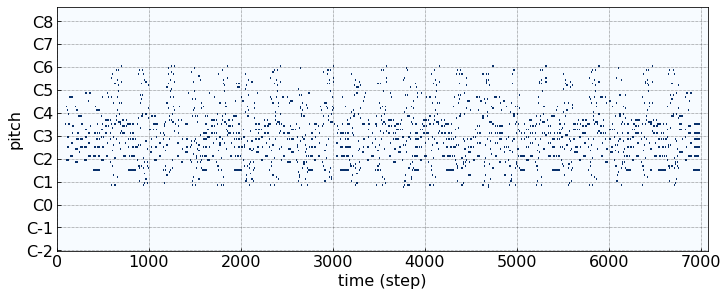

In [15]:
pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM)

# tempo = 80
tempo = 120

# f0 = copy.deepcopy(test_file)
# dataset.write_midi(f0, str(P / 'audio_output' / (FILE + '_filled_rnn.mid')),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

# f1 = copy.deepcopy(ff_file)
# dataset.write_midi(f1, str(P / 'audio_output' / (FILE + '_filled_ff.mid')),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

# f3 = copy.deepcopy(base_file)
# dataset.write_midi(f3, str(P / 'audio_output' / (FILE + '_filled_base.mid')),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

f0 = copy.deepcopy(test_file)
dataset.write_midi(f0, ('audio_output/_filled_ff001.mid'),
                   LOW_LIM, HIGH_LIM, tempo=tempo, br=24)
print(FILE)

# f1 = copy.deepcopy(ff_file)
# dataset.write_midi(f1, (FILE + '_filled_ff.mid'),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

# f3 = copy.deepcopy(base_file)
# dataset.write_midi(f3, (FILE + '_filled_base.mid'),
#                    LOW_LIM, HIGH_LIM, tempo=tempo, br=24)

In [16]:
# end = STOP + 120

# past = dataset.downsample_roll(test_file[STOP:end, :], 10, 12)
# past = np.array([past])

# predictions = model.predict(past)
# predictions_bin = dataset.ranked_threshold(predictions, steps=10, how_many=5)
# predictions_bin = predictions_bin.reshape((10, 64))
# # pyplot_piano_roll(predictions_bin, low_lim=+LOW_LIM, high_lim=HIGH_LIM)

# upsampled = copy.deepcopy(predictions_bin)
# upsampled = dataset.upsample_roll(upsampled, 10, 12)
# # pyplot_piano_roll(arr, low_lim=+LOW_LIM, high_lim=HIGH_LIM)

# final = copy.deepcopy(test_file)
# final[end: end+12*5] = upsampled[:12*5]
